<a href="https://colab.research.google.com/github/jmolins89/final-project/blob/master/New_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

# Loading data ...

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
categories=['NORMAL','PNEUMONIA']
IMG_SIZE=200

def create_training_data(datadir,IMG_SIZE):
    '''
    '''
    lst=[]
    categories = ['NORMAL', 'PNEUMONIA']
    for category in categories:
        path = os.path.join(datadir, category)  # path to normal or pneumonia
        class_num=categories.index(category)    # Set category by index in categories: 0 -> Normal, 1 -> Pneumonia
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)   # read the original image
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # resizes the original image to a IMG_SIZE
                lst.append([new_array,class_num])     # Appends to the list a tuple with array resized and each label
            except Exception as e:
                pass
    return lst

training_data = create_training_data('/content/drive/My Drive/chest_xray/train',200)
test_data = create_training_data('/content/drive/My Drive/chest_xray/test',200)
validation_data = create_training_data('/content/drive/My Drive/chest_xray/val',200)

In [0]:
random.shuffle(training_data)
random.shuffle(test_data)
random.shuffle(validation_data)

In [0]:
def createxy(data):
    X,y=[],[]
    for features,label in data:
        X.append(features/255)
        y.append(label)
    return X,y
def createxyshuffled(data):
    X,y=[],[]
    for features,label in data:
        X.append(features)
        y.append(label)
    return X,y

In [0]:
X_train,y_train = createxy(training_data)
X_test,y_test = createxy(test_data)
X_val,y_val = createxy(validation_data)

In [0]:
X_train=np.array(X_train).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_test=np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_val=np.array(X_val).reshape(-1,IMG_SIZE,IMG_SIZE,1)


# Exporting arrays with images and labels

In [0]:
import pickle

pickle_out = open('X_train.pickle','wb')
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open('y_train.pickle','wb')
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open('X_test.pickle','wb')
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open('y_test.pickle','wb')
pickle.dump(y_test, pickle_out)
pickle_out.close()

pickle_out = open('X_val.pickle','wb')
pickle.dump(X_val, pickle_out)
pickle_out.close()

pickle_out = open('y_val.pickle','wb')
pickle.dump(y_val, pickle_out)
pickle_out.close()

In [0]:
import pickle
pickle_in1=open('/content/drive/My Drive/X_train.pickle','rb')
pickle_in2=open('/content/drive/My Drive/y_train.pickle','rb')
pickle_in3=open('/content/drive/My Drive/X_test.pickle','rb')
pickle_in4=open('/content/drive/My Drive/y_test.pickle','rb')
pickle_in5=open('/content/drive/My Drive/X_val.pickle','rb')
pickle_in6=open('/content/drive/My Drive/y_val.pickle','rb')

X_train,y_train=pickle.load(pickle_in1),pickle.load(pickle_in2)
X_test,y_test=pickle.load(pickle_in3),pickle.load(pickle_in4)
X_val,y_val=pickle.load(pickle_in5),pickle.load(pickle_in6)

In [0]:
len(X_train)

5216

In [4]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.callbacks import TensorBoard
from time import time
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import ReLU
import imageio
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


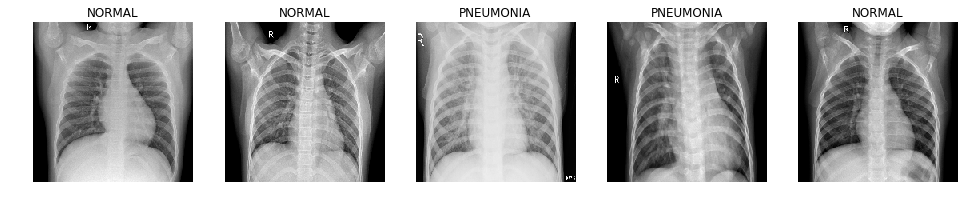

In [7]:
dic={0:'NORMAL',1:'PNEUMONIA'}
plt.figure(figsize=(20,12))
for index,img in enumerate(X_train[:5]):  
    plt.subplot(1,6,index+1)
    plt.imshow(img.reshape(200,200), cmap='gray')
    plt.axis('off')
    plt.title(dic.get(y_train[index]))
plt.show()

In the previous images **we can't distinguish the case with pneumonia against the case without pneumonia** if don't know anything about chest X-Ray reading.

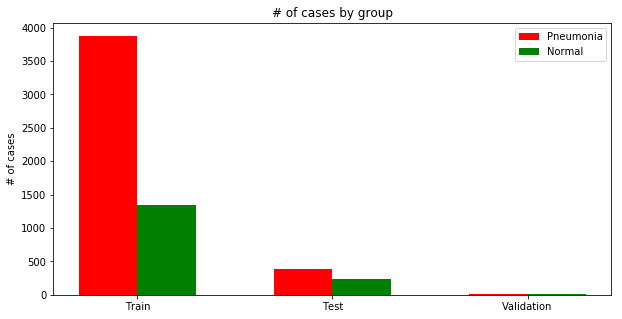

In [8]:
N = 3
normal=(y_train.count(0),y_test.count(0),y_val.count(0))
pneumonia=(y_train.count(1),y_test.count(1),y_val.count(1))
ind = np.arange(N)    # the x locations for the groups
width = 0.3       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(10,5))
p1 = plt.bar(ind-0.15, pneumonia, width,color='r')
p2 = plt.bar(ind+0.15, normal, width, color='g')
plt.ylabel('# of cases')
plt.title('# of cases by group')
plt.xticks(ind, ('Train', 'Test', 'Validation'))
plt.yticks(np.arange(0, 4500, 500))
plt.legend((p1[0], p2[0]), ('Pneumonia','Normal'))

plt.show()



In the previous graph we can observe that **the data is unbalanced**, because we have more Pneumonia cases than Normal.

We have to **rebalance** the data to train better a neural network.

We are going to **generate random images of Normal cases**.



In [0]:
np.bincount(y_train)

array([1341, 3875])

In [4]:
print('{} normal cases to create for train data'.format(np.bincount(y_train)[1]-np.bincount(y_train)[0]))

2534 normal cases to create for train data


## **Creando generador imágenes**

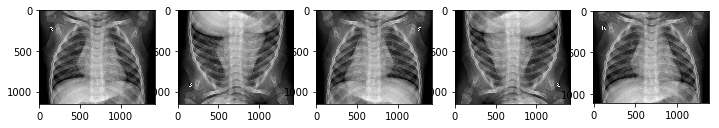

In [9]:
from google.colab.patches import cv2_imshow
imageSource = '/content/drive/My Drive/chest_xray/train/NORMAL/IM-0117-0001.jpeg'
img = cv2.imread(imageSource)
 
# copy image to display all 4 variations
horizontal_img = img.copy()
vertical_img = img.copy()
both_img = img.copy()
 
# flip img horizontally, vertically,
# and both axes with flip()
horizontal_img = cv2.flip( img, 0 )
vertical_img = cv2.flip( img, 1 )
both_img = cv2.flip( img, -1 )
 
# display the images on screen with imshow()
plt.figure(figsize=(12,4))
plt.subplot(1,5,1)
plt.imshow(img )
plt.subplot(1,5,2)
plt.imshow(horizontal_img )
plt.subplot(1,5,3)
plt.imshow(vertical_img )
plt.subplot(1,5,4)
plt.imshow( both_img )
plt.subplot(1,5,5)
plt.imshow(img[20:-20,20:-20] )
 
# wait time in milliseconds
# this is required to show the image
# 0 = wait indefinitely
cv2.waitKey(0)
 
# close the windows
cv2.destroyAllWindows()

In [0]:
normalindex=[i for i,e in enumerate(y_train) if e==0 ]
new_images=[]
new_labels=[]
for imagen in X_train[normalindex]:
  new_img = imagen[20:-20,20:-20].copy()
  new_img = cv2.resize(new_img,(200,200))
  new_images.append(new_img)
  new_labels.append(0)
  cv2.waitKey(0)

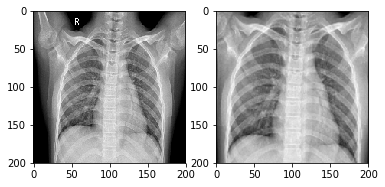

In [6]:
plt.subplot(1,2,1)
plt.imshow(X_train[normalindex][1].reshape(200,200), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(new_images[1].reshape(200,200),cmap='gray')
plt.show()

In [7]:
a=X_train
b=np.array(new_images).reshape(-1,200,200,1)
c=y_train
d=np.array(new_labels)

print(len(a))
print(len(b))
X_train_more_data = np.concatenate((a,b),axis=0)
y_train_more_data = np.concatenate((c,d),axis=0)
print(len(X_train_more_data))
print(len(y_train_more_data))
np.bincount(y_train_more_data)

5216
1341
6557
6557


array([2682, 3875])

In [8]:
to_shuffle_train=[]
for i in range(len(X_train_more_data)):
  to_shuffle_train.append([X_train_more_data[i],y_train_more_data[i]])
print('len:',len(to_shuffle_train))

len: 6557


In [0]:
random.shuffle(to_shuffle_train)

In [0]:
X_train_more_data,y_train_more_data=createxyshuffled(to_shuffle_train)
X_train_more_data=np.array(X_train_more_data).reshape(-1,200,200,1)

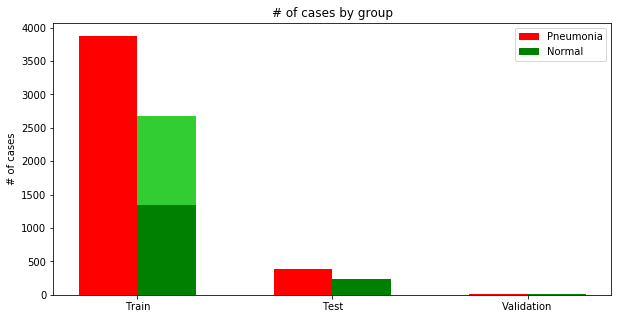

In [26]:
N = 3
normal0=(y_train.count(0),y_test.count(0),y_val.count(0))
normal=(np.bincount(y_train_more_data)[0],y_test.count(0),y_val.count(0))
pneumonia=(np.bincount(y_train_more_data)[1],y_test.count(1),y_val.count(1))
ind = np.arange(N)    # the x locations for the groups
width = 0.3       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(10,5))
p1 = plt.bar(ind-0.15, pneumonia, width,color='r')
p2 = plt.bar(ind+0.15, normal, width, color='limegreen')
p2 = plt.bar(ind+0.15, normal0, width, color='g')
plt.ylabel('# of cases')
plt.title('# of cases by group')
plt.xticks(ind, ('Train', 'Test', 'Validation'))
plt.yticks(np.arange(0, 4500, 500))
plt.legend((p1[0], p2[0]), ('Pneumonia','Normal'))

plt.show()

# Convolutional Neural Network

In [0]:
from keras.utils import to_categorical
y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)
y_val_binary = to_categorical(y_val)
y_train_more_data_binary = to_categorical(y_train_more_data)

In [12]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(200, 200,1), activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=2, activation='softmax'))
model.summary()

W0805 10:47:48.661084 140539494291328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 10:47:48.676573 140539494291328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 10:47:48.679349 140539494291328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 10:47:48.703761 140539494291328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0805 10:47:48.706174 140539494291328 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 94, 94, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 64)        0         
__________

In [13]:
#def auc_metric(y_true, y_pred):
#  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred,pos_label=1)
#  auc = metrics.auc(fpr, tpr)
#  return auc

model.compile(
    loss='categorical_crossentropy',  # we train 2-way classification
    optimizer=keras.optimizers.Adadelta(),  # for SGD
    metrics=['accuracy'],  # report accuracy during training
    #shuffle=True,
    #verbose=1
)
#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
modeltrain = model.fit(x=X_train_more_data,y=y_train_more_data_binary, epochs=30,#,callbacks=[tensorboard])#,
                   validation_split=0.1, batch_size=128,shuffle=True)

W0805 10:47:59.164657 140539494291328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 10:47:59.173591 140539494291328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0805 10:47:59.270426 140539494291328 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 5901 samples, validate on 656 samples
Epoch 1/30
5901/5901 [==============================] - 26s 4ms/step - loss: 0.6816 - acc: 0.5850 - val_loss: 0.6734 - val_acc: 0.5991
Epoch 2/30
5901/5901 [==============================] - 17s 3ms/step - loss: 0.6024 - acc: 0.6665 - val_loss: 0.4424 - val_acc: 0.7957
Epoch 3/30
5901/5901 [==============================] - 17s 3ms/step - loss: 0.4044 - acc: 0.8283 - val_loss: 0.4252 - val_acc: 0.8186
Epoch 4/30
5901/5901 [==============================] - 18s 3ms/step - loss: 0.2809 - acc: 0.8870 - val_loss: 0.2360 - val_acc: 0.9055
Epoch 5/30
5901/5901 [==============================] - 17s 3ms/step - loss: 0.2153 - acc: 0.9170 - val_loss: 0.2298 - val_acc: 0.9101
Epoch 6/30
5901/5901 [==============================] - 18s 3ms/step - loss: 0.1990 - acc: 0.9224 - val_loss: 0.3111 - val_acc: 0.9040
Epoch 7/30
5901/5901 [==============================] - 18s 3ms/step - loss: 0.1667 - acc: 0.9390 - val_loss: 0.4827 - val_acc: 0.7835
Epoch 8/

In [0]:
len(X_train_more_data)

6557

In [0]:
modeltrain.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

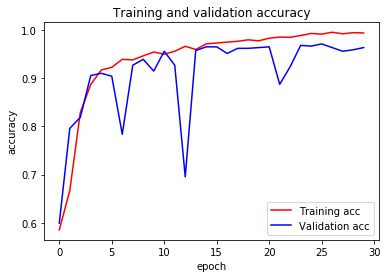

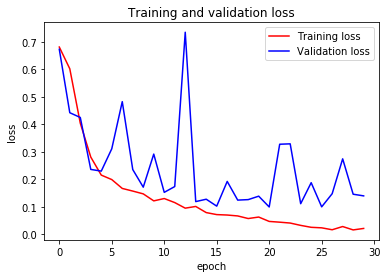

In [14]:
#Graphing our training and validation
acc = modeltrain.history['acc']
val_acc = modeltrain.history['val_acc']
loss = modeltrain.history['loss']
val_loss = modeltrain.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [15]:
val_loss,val_acc = model.evaluate(X_test,y_test_binary)
print(val_loss,val_acc)

624/624 [==============================] - 1s 2ms/step
1.3010572615342262 0.8141025641025641


In [0]:
predictions=model.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test_binary.argmax(axis=1), predictions.argmax(axis=1))


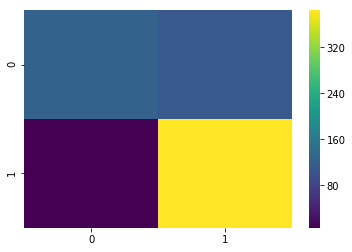

In [18]:
import seaborn as sns
sns.heatmap(matrix, cmap='viridis');

In [19]:
matrix

array([[124, 110],
       [  6, 384]])

In [0]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)#, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Normalized confusion matrix


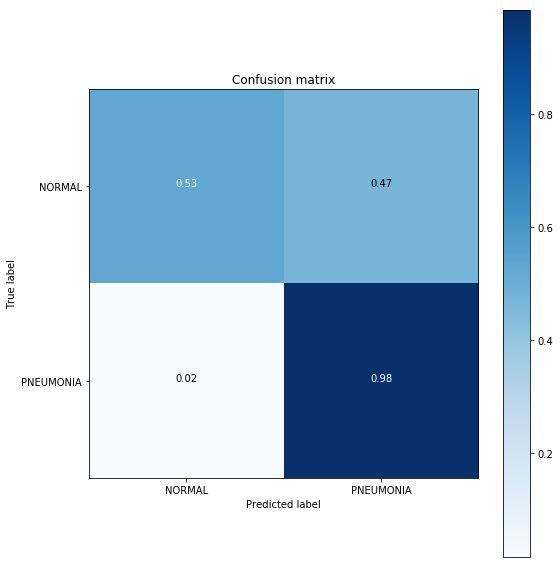

In [21]:
preds = np.argmax(model.predict(X_test), axis = 1)
cm = confusion_matrix([np.argmax(i) for i in y_test_binary],preds)
keys = ['NORMAL','PNEUMONIA']
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)

In [45]:
from sklearn.metrics import roc_curve, auc
y_true=np.array([np.argmax(y_test_binary[i]) for i in range(len(y_test_binary))])
y_pred=np.array([predictions[i][np.argmax(predictions[i])] for i in range(len(predictions))])
fpr, tpr, thresholds = roc_curve(y_true, y_pred,pos_label=1)
auc = auc(fpr, tpr)
print(auc)

0.8777065527065527


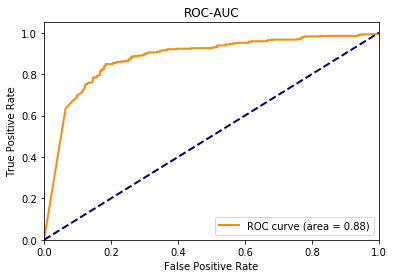

In [23]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC')
plt.legend(loc="lower right")
plt.show()

# Generando más imágenes para balancear la muestra

In [0]:
new_images2=[]
new_labels2=[]
for imagen in X_train[normalindex]:
  new_img = imagen[15:-15,15:-15].copy()
  new_img = cv2.resize(new_img,(200,200))
  new_images2.append(new_img)
  new_labels2.append(0)
  cv2.waitKey(0)

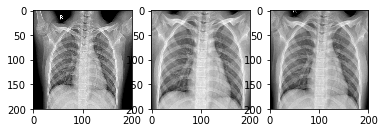

In [25]:
plt.subplot(1,3,1)
plt.imshow(X_train[normalindex][1].reshape(200,200), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(new_images[1].reshape(200,200),cmap='gray')
plt.subplot(1,3,3)
plt.imshow(new_images2[1].reshape(200,200),cmap='gray')
plt.show()

In [26]:
a=X_train_more_data
b=np.array(new_images2).reshape(-1,200,200,1)
c=y_train_more_data
d=np.array(new_labels2)

print(len(a))
print(len(b))
X_train_more_data2 = np.concatenate((a,b),axis=0)
y_train_more_data2 = np.concatenate((c,d),axis=0)
print(len(X_train_more_data2))
print(len(y_train_more_data2))
np.bincount(y_train_more_data2)

6557
1341
7898
7898


array([4023, 3875])

In [27]:
to_shuffle_train2=[]
for i in range(len(X_train_more_data2)):
  to_shuffle_train2.append([X_train_more_data2[i],y_train_more_data2[i]])
print('len:',len(to_shuffle_train2))



len: 7898


In [0]:
random.shuffle(to_shuffle_train2)

In [0]:
X_train_more_data2,y_train_more_data2=createxyshuffled(to_shuffle_train2)
X_train_more_data2=np.array(X_train_more_data2).reshape(-1,200,200,1)

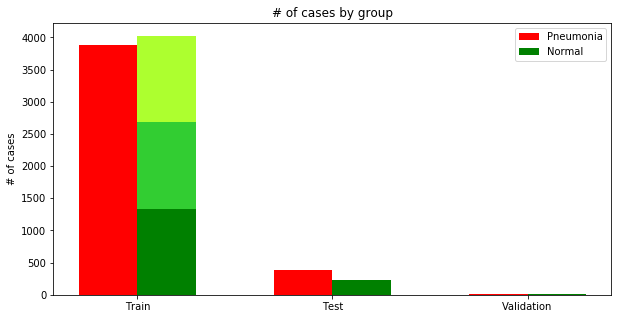

In [30]:
N = 3
normal0=(y_train.count(0),y_test.count(0),y_val.count(0))
normal=(np.bincount(y_train_more_data)[0],y_test.count(0),y_val.count(0))
normal2=(np.bincount(y_train_more_data2)[0],y_test.count(0),y_val.count(0))
pneumonia=(np.bincount(y_train_more_data)[1],y_test.count(1),y_val.count(1))
ind = np.arange(N)    # the x locations for the groups
width = 0.3       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(10,5))
p1 = plt.bar(ind-0.15, pneumonia, width,color='r')
p2 = plt.bar(ind+0.15, normal2, width, color='greenyellow')
p2 = plt.bar(ind+0.15, normal, width, color='limegreen')
p2 = plt.bar(ind+0.15, normal0, width, color='g')
plt.ylabel('# of cases')
plt.title('# of cases by group')
plt.xticks(ind, ('Train', 'Test', 'Validation'))
plt.yticks(np.arange(0, 4500, 500))
plt.legend((p1[0], p2[0]), ('Pneumonia','Normal'))

plt.show()

In [0]:
from keras.utils import to_categorical
y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)
y_val_binary = to_categorical(y_val)
y_train_more_data2_binary = to_categorical(y_train_more_data2)

In [32]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(200, 200,1), activation='relu'))
model2.add(Conv2D(32,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(32, (3,3), activation='relu'))
model2.add(Conv2D(32,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units=2, activation='softmax'))
model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 198, 198, 32)      320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 196, 196, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 94, 94, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 47, 47, 64)        0         
__________

In [33]:
model2.compile(
    loss='categorical_crossentropy',  # we train 2-way classification
    optimizer=keras.optimizers.Adadelta(),  # for SGD
    metrics=['accuracy'],  # report accuracy during training
)

modeltrain2 = model2.fit(x=X_train_more_data2,y=y_train_more_data2_binary, epochs=30,#,callbacks=[tensorboard])#,
                   validation_split=0.1, batch_size=128,shuffle=True)

Train on 7108 samples, validate on 790 samples
Epoch 1/30
7108/7108 [==============================] - 25s 3ms/step - loss: 0.7095 - acc: 0.5827 - val_loss: 0.6933 - val_acc: 0.5038
Epoch 2/30
7108/7108 [==============================] - 21s 3ms/step - loss: 0.6735 - acc: 0.6225 - val_loss: 0.4592 - val_acc: 0.8443
Epoch 3/30
7108/7108 [==============================] - 21s 3ms/step - loss: 0.6743 - acc: 0.5943 - val_loss: 0.6956 - val_acc: 0.4962
Epoch 4/30
7108/7108 [==============================] - 21s 3ms/step - loss: 0.6912 - acc: 0.5516 - val_loss: 0.6932 - val_acc: 0.4962
Epoch 5/30
7108/7108 [==============================] - 21s 3ms/step - loss: 0.5279 - acc: 0.7555 - val_loss: 0.3646 - val_acc: 0.8570
Epoch 6/30
7108/7108 [==============================] - 22s 3ms/step - loss: 0.3678 - acc: 0.8412 - val_loss: 0.3262 - val_acc: 0.9051
Epoch 7/30
7108/7108 [==============================] - 22s 3ms/step - loss: 0.3232 - acc: 0.8662 - val_loss: 0.2312 - val_acc: 0.9127
Epoch 8/

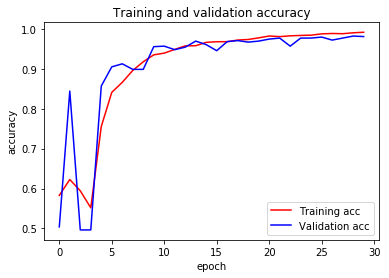

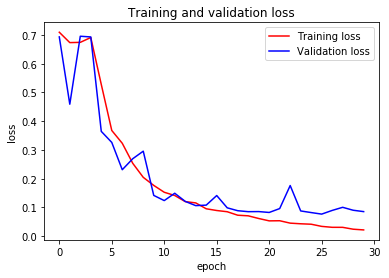

In [34]:
#Graphing our training and validation
acc = modeltrain2.history['acc']
val_acc = modeltrain2.history['val_acc']
loss = modeltrain2.history['loss']
val_loss = modeltrain2.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [35]:
val_loss,val_acc = model2.evaluate(X_test,y_test_binary)
print(val_loss,val_acc)

624/624 [==============================] - 1s 1ms/step
0.9741134353173084 0.8253205128205128


In [0]:
predictions2=model2.predict(X_test)
matrix2 = confusion_matrix(y_test_binary.argmax(axis=1), predictions2.argmax(axis=1))


Normalized confusion matrix


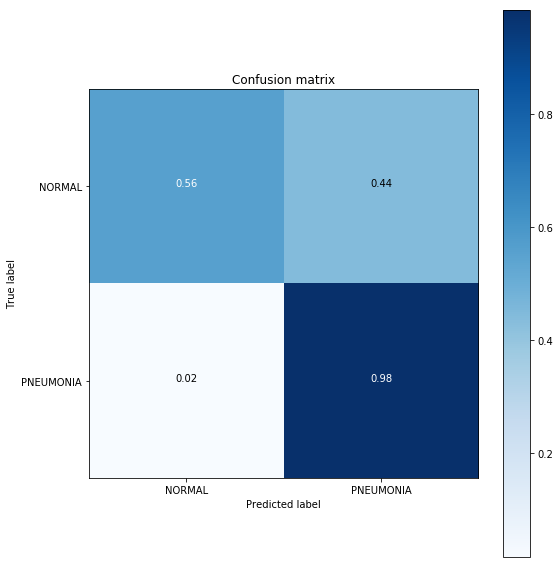

In [38]:
preds2 = np.argmax(model2.predict(X_test), axis = 1)
cm2 = confusion_matrix([np.argmax(i) for i in y_test_binary],preds2)
keys = ['NORMAL','PNEUMONIA']
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm2, keys, normalize=True)

In [46]:
from sklearn.metrics import roc_curve, auc
y_true=np.array([np.argmax(y_test_binary[i]) for i in range(len(y_test_binary))])
y_pred=np.array([predictions[i][np.argmax(predictions[i])] for i in range(len(predictions))])
fpr, tpr, thresholds = roc_curve(y_true, y_pred,pos_label=1)
auc = auc(fpr, tpr)
print(auc)

0.8777065527065527


In [48]:
y_true2=np.array([np.argmax(y_test_binary[i]) for i in range(len(y_test_binary))])
y_pred2=np.array([predictions2[i][np.argmax(predictions2[i])] for i in range(len(predictions2))])
fpr2, tpr2, thresholds2 = roc_curve(y_true2, y_pred2,pos_label=1)
auc2 = auc(fpr2, tpr2)
print(tpr2)

[0.         0.38974359 0.47179487 0.51794872 0.53333333 0.55897436
 0.61025641 0.62564103 0.63589744 0.64358974 0.64615385 0.65641026
 0.66923077 0.67179487 0.67692308 0.68461538 0.68974359 0.69487179
 0.6974359  0.7025641  0.70512821 0.70769231 0.71282051 0.71538462
 0.72051282 0.72051282 0.72564103 0.72820513 0.73333333 0.73333333
 0.73846154 0.74358974 0.74358974 0.75384615 0.75384615 0.75897436
 0.76410256 0.77948718 0.77948718 0.79487179 0.79487179 0.7974359
 0.8025641  0.81282051 0.81282051 0.81538462 0.81794872 0.83076923
 0.83076923 0.83333333 0.83333333 0.83589744 0.83589744 0.83846154
 0.83846154 0.84102564 0.84102564 0.84615385 0.84615385 0.84871795
 0.84871795 0.85128205 0.85384615 0.85384615 0.85384615 0.85641026
 0.85641026 0.86153846 0.86153846 0.86410256 0.86410256 0.87179487
 0.87179487 0.87435897 0.87435897 0.87692308 0.87692308 0.87948718
 0.87948718 0.88205128 0.88205128 0.88717949 0.88717949 0.89230769
 0.89230769 0.89487179 0.89487179 0.8974359  0.8974359  0.9
 0.

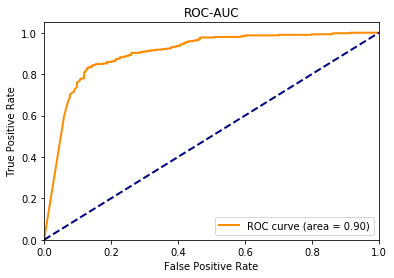

In [57]:
plt.figure()
lw = 2
plt.plot(fpr2, tpr2, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC')
plt.legend(loc="lower right")
plt.show();

In [0]:
classifier=Sequential()
#changes for thaneo
#activation fn-rectifier

classifier.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=(200,200,1),activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))


classifier.add(Flatten())
#full connwection--output either sigmoid or softmax
classifier.add(Dense(output_dim=128,activation='relu'))

classifier.add(Dense(output_dim=2,activation='softmax'))
#compile
classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 198, 198, 64)      640       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 97, 97, 32)        18464     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               9437312   
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 258       
Total para

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=2)`
  app.launch_new_instance()


In [0]:
history=classifier.fit(x=X_train_more_data,y=y_train_more_data_binary, epochs=10,#,callbacks=[tensorboard])#,
                   validation_split=0.1, batch_size=128)

Train on 5901 samples, validate on 656 samples
Epoch 1/10
5901/5901 [==============================] - 10s 2ms/step - loss: 0.4828 - acc: 0.7661 - val_loss: 0.1977 - val_acc: 0.9543
Epoch 2/10
5901/5901 [==============================] - 10s 2ms/step - loss: 0.1643 - acc: 0.9375 - val_loss: 0.1665 - val_acc: 0.9466
Epoch 3/10
5901/5901 [==============================] - 10s 2ms/step - loss: 0.1129 - acc: 0.9553 - val_loss: 0.0816 - val_acc: 0.9726
Epoch 4/10
5901/5901 [==============================] - 10s 2ms/step - loss: 0.0838 - acc: 0.9690 - val_loss: 0.2041 - val_acc: 0.9116
Epoch 5/10
5901/5901 [==============================] - 10s 2ms/step - loss: 0.0640 - acc: 0.9754 - val_loss: 0.0634 - val_acc: 0.9802
Epoch 6/10
5901/5901 [==============================] - 9s 2ms/step - loss: 0.0569 - acc: 0.9798 - val_loss: 0.1490 - val_acc: 0.9405
Epoch 7/10
5901/5901 [==============================] - 10s 2ms/step - loss: 0.0345 - acc: 0.9888 - val_loss: 0.0537 - val_acc: 0.9878
Epoch 8/1